## Step 0: Colab env
Uploading and installing dependencies

In [65]:
!pip install archspec==0.2.3 \
asttokens==2.4.1 \
boltons==23.0.0 \
Brotli==1.0.9 \
charset-normalizer==2.0.4 \
colorama==0.4.6 \
comm==0.2.2 \
cryptography==42.0.5 \
decorator==4.4.2 \
distro==1.9.0 \
executing==2.0.1 \
frozendict==2.4.2 \
idna==3.7 \
jedi==0.19.1 \
jsonpatch==1.33 \
jsonpointer==2.1 \
nest-asyncio==1.6.0 \
packaging==23.2 \
parso==0.8.4 \
platformdirs==4.2.1 \
pluggy==1.0.0 \
pure-eval==0.2.2 \
pycosat==0.6.6 \
pycparser==2.21 \
Pygments==2.18.0 \
PySocks==1.7.1 \
requests==2.32.3 \
ruamel.yaml==0.17.21 \
stack-data==0.6.3 \
tqdm==4.66.4 \
traitlets==5.14.3 \
truststore==0.8.0 \
urllib3==2.2.2 \
zstandard==0.22.0 \
pykan

  Using cached archspec-0.2.3-py3-none-any.whl.metadata (4.4 kB)
  Using cached boltons-23.0.0-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached Brotli-1.0.9.zip (510 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached charset_normalizer-2.0.4-py3-none-any.whl.metadata (11 kB)
  Using cached cryptography-42.0.5-cp39-abi3-win_amd64.whl.metadata (5.4 kB)
  Using cached decorator-4.4.2-py2.py3-none-any.whl.metadata (4.2 kB)
  Using cached distro-1.9.0-py3-none-any.whl.metadata (6.8 kB)
  Using cached executing-2.0.1-py2.py3-none-any.whl.metadata (9.0 kB)
  Using cached frozendict-2.4.2-cp312-cp312-win_amd64.whl
  Using cached idna-3.7-py3-none-any.whl.metadata (9.9 kB)
  Using cached jsonpatch

  error: subprocess-exited-with-error
  
  × Building wheel for Brotli (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [26 lines of output]
      C:\Users\how2t\AppData\Local\Temp\pip-build-env-6kyraoay\overlay\Lib\site-packages\setuptools\_distutils\dist.py:261: UserWarning: Unknown distribution option: 'test_suite'
        warnings.warn(msg)
      C:\Users\how2t\AppData\Local\Temp\pip-build-env-6kyraoay\overlay\Lib\site-packages\setuptools\dist.py:495: SetuptoolsDeprecationWarning: Invalid dash-separated options
      !!
      
              ********************************************************************************
              Usage of dash-separated 'build-base' will not be supported in future
              versions. Please use the underscore name 'build_base' instead.
      
              By 2025-Mar-03, you need to update your project and remove deprecated calls
              or your builds will no longer be supported.
      
              See https://set

## Step 1: Import Libraries and Set Up the Environment
Starting with libs and setting up device. If possible use GPU

In [66]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from kan import KAN
from tqdm import tqdm
from torch.amp import GradScaler, autocast

# torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_type = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cpu


In [67]:
transform = transforms.Compose([
    transforms.ToTensor(),  # PIL Image -> Tensor
    transforms.Normalize((0.1307,), (0.3081,)) #normalizing dataset 
    ]) 

#Download MNIST dataset and used the transform to convert the data to tensor and normalize it
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

#Create DataLoader to batch and shuffle the data using mulitprocessing
train_loader = DataLoader(dataset=train_dataset, batch_size=4096, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1024, shuffle=False, num_workers=4, pin_memory=True)

In [68]:
class MLP(nn.Module):
    def __init__(self, width):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(width) - 1):
            layers.append(nn.Linear(width[i], width[i+1]))
            if i < len(width) - 2:
                layers.append(nn.ReLU())
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [69]:
# Instantiate the MLP modelMLP
modelMLP = MLP(width=[784, 32, 16, 10]).to(device).float()
modelKAN = KAN(width=[784, 32, 16, 10], grid=5, k=3, seed=42, device=device).to(device).float()

checkpoint directory created: ./model
saving model version 0.0


In [70]:
# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizerMLP = torch.optim.Adam(modelMLP.parameters(), lr=0.002)
optimizerKAN = torch.optim.Adam(modelKAN.parameters(), lr=0.002)

Epoch [1/1]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/1]: 100%|██████████| 15/15 [04:33<00:00, 18.22s/it]


Epoch [1/1] | MLP Loss: 1.9206 | MLP Test Acc: 58.42% | KAN Loss: 1.8364 | KAN Test Acc: 62.66%


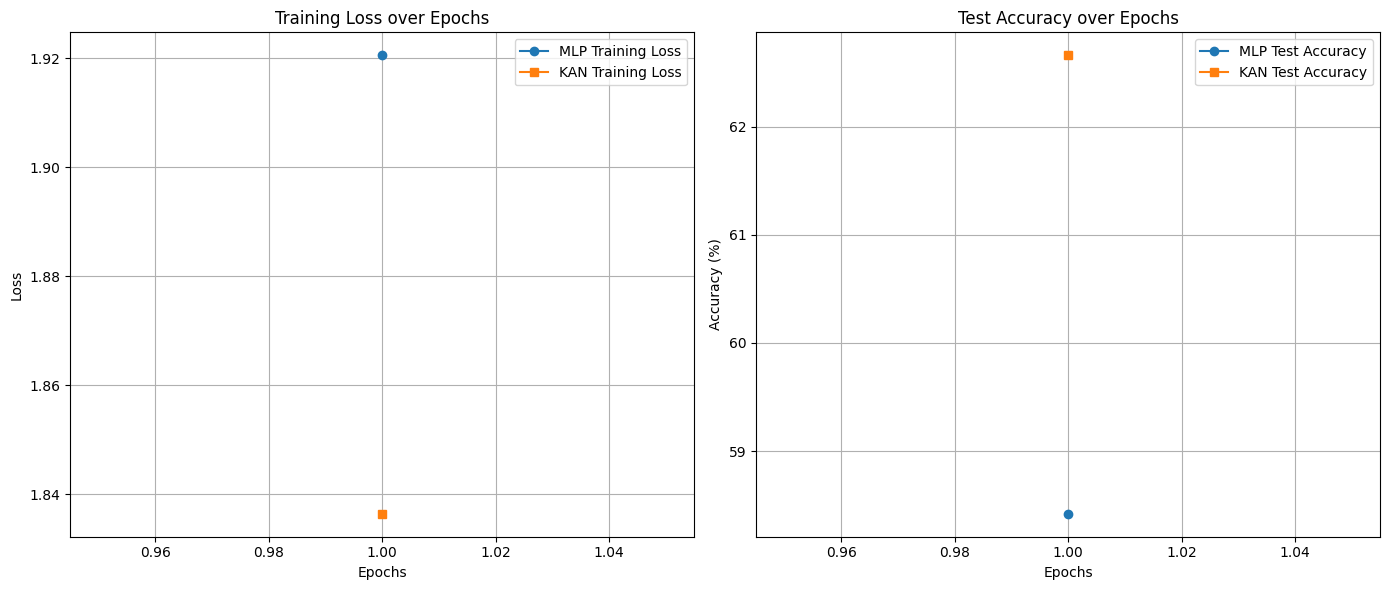

In [ ]:
use_amp = torch.cuda.is_available()

scalerMLP = GradScaler(device='cuda', enabled=use_amp)
scalerKAN = GradScaler(device='cuda', enabled=use_amp)

train_losses_MLP = []
train_losses_KAN = []
test_accuracies_MLP = []
test_accuracies_KAN = []

# Number of training epochs
num_epochs = 5  # Set to 1 for initial testing; adjust as needed

for epoch in range(num_epochs):
    # Set both models to training mode
    modelMLP.train()
    modelKAN.train()

    # Initialize running loss and correct predictions counters
    running_loss_MLP = 0.0
    running_loss_KAN = 0.0
    correct_MLP = 0
    correct_KAN = 0
    total = 0

    # Iterate over the training dataset
    for images, labels in tqdm(train_loader, desc=f'Epoch [{epoch+1}/{num_epochs}]'):
        # Move data to the configured device and flatten images
        images = images.view(images.size(0), -1).to(device)
        labels = labels.to(device)

        ####### Training MLP #######
        optimizerMLP.zero_grad()

        with torch.autocast(device_type=device_type, enabled=torch.cuda.is_available()):
            outputs_MLP = modelMLP(images)
            loss_MLP = criterion(outputs_MLP, labels)

        scalerMLP.scale(loss_MLP).backward()  # Backward pass for MLP
        scalerMLP.step(optimizerMLP)          # Update MLP parameters
        scalerMLP.update()

        running_loss_MLP += loss_MLP.item() 

        _, predicted_MLP = torch.max(outputs_MLP, 1)
        correct_MLP += (predicted_MLP == labels).sum().item()

        ####### Training KAN #######
        optimizerKAN.zero_grad()

        with torch.autocast(device_type=device_type, enabled=torch.cuda.is_available()):
            outputs_KAN = modelKAN(images)
            loss_KAN = criterion(outputs_KAN, labels)

        scalerKAN.scale(loss_KAN).backward()  # Backward pass for KAN
        scalerKAN.step(optimizerKAN)           # Update KAN parameters
        scalerKAN.update()

        running_loss_KAN += loss_KAN.item()    # Accumulate KAN loss

        _, predicted_KAN = torch.max(outputs_KAN, 1)
        correct_KAN += (predicted_KAN == labels).sum().item()

        total += labels.size(0)

    # Calculate average losses for the epoch
    avg_loss_MLP = running_loss_MLP / len(train_loader)
    avg_loss_KAN = running_loss_KAN / len(train_loader)

    train_losses_MLP.append(avg_loss_MLP)
    train_losses_KAN.append(avg_loss_KAN)

    ####### Evaluation #######
    # Set both models to evaluation mode
    modelMLP.eval()
    modelKAN.eval()

    correct_MLP_test = 0
    correct_KAN_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(images.size(0), -1).to(device)
            labels = labels.to(device)
            
            # Evaluate MLP
            outputs_MLP = modelMLP(images)
            _, predicted_MLP = torch.max(outputs_MLP, 1)
            correct_MLP_test += (predicted_MLP == labels).sum().item()
            
            # Evaluate KAN
            outputs_KAN = modelKAN(images)
            _, predicted_KAN = torch.max(outputs_KAN, 1)
            correct_KAN_test += (predicted_KAN == labels).sum().item()
            
            total_test += labels.size(0)

    # Calculate test accuracies
    test_accuracy_MLP = 100 * correct_MLP_test / total_test
    test_accuracy_KAN = 100 * correct_KAN_test / total_test

    test_accuracies_MLP.append(test_accuracy_MLP)
    test_accuracies_KAN.append(test_accuracy_KAN)

    # Print epoch summary
    print(f'Epoch [{epoch+1}/{num_epochs}] '
          f'| MLP Loss: {avg_loss_MLP:.4f} | MLP Test Acc: {test_accuracy_MLP:.2f}% '
          f'| KAN Loss: {avg_loss_KAN:.4f} | KAN Test Acc: {test_accuracy_KAN:.2f}%')

####### Plotting #######
plt.figure(figsize=(14, 6))

# Plot Training Losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses_MLP, label='MLP Training Loss', marker='o')
plt.plot(range(1, num_epochs+1), train_losses_KAN, label='KAN Training Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)

# Plot Test Accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), test_accuracies_MLP, label='MLP Test Accuracy', marker='o')
plt.plot(range(1, num_epochs+1), test_accuracies_KAN, label='KAN Test Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()